In [7]:
!pip install torchbnn

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchbnn as bnn
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, root_mean_squared_error, explained_variance_score
import seaborn as sns

In [24]:
df = pd.read_csv("/content/drive/MyDrive/Advancing Machine Learning/exercise_1/preprocessed/processed_regression.csv")



In [25]:
df.tail()

,Hours_Studied,Attendance,Parental_Involvement,Access_to_Resources,Extracurricular_Activities,Sleep_Hours,Previous_Scores,Motivation_Level,Internet_Access,Tutoring_Sessions,Family_Income,Teacher_Quality,School_Type,Peer_Influence,Physical_Activity,Learning_Disabilities,Parental_Education_Level,Distance_from_Home,Gender,Exam_Score
5466,25,69,2,0,0,7,76,0,1,1,2,0,1,0,2,0,0,0,0,68
5467,23,76,2,0,0,8,81,0,1,3,1,2,1,0,2,0,0,0,0,69
5468,20,90,0,1,1,6,65,1,1,3,1,0,1,1,2,0,2,0,0,68
5469,10,86,2,2,1,6,91,2,1,2,1,0,0,0,3,0,0,1,0,68
5470,15,67,0,1,1,9,94,0,1,0,0,0,1,0,4,0,2,0,1,64


In [26]:
num_samples_to_select = 3000

if len(df) > num_samples_to_select:
    df = df.sample(n=num_samples_to_select, random_state=42).reset_index(drop=True)
    print(f"Dataset reduced to {num_samples_to_select} samples.")
else:
    print(f"Dataset has {len(df)} samples, which is less than or equal to the requested {num_samples_to_select}. Using all available samples.")

df.tail()

Dataset reduced to 3000 samples.


,Hours_Studied,Attendance,Parental_Involvement,Access_to_Resources,Extracurricular_Activities,Sleep_Hours,Previous_Scores,Motivation_Level,Internet_Access,Tutoring_Sessions,Family_Income,Teacher_Quality,School_Type,Peer_Influence,Physical_Activity,Learning_Disabilities,Parental_Education_Level,Distance_from_Home,Gender,Exam_Score
2995,32,88,0,1,1,7,83,1,1,1,1,2,0,0,4,0,2,0,1,73
2996,19,84,1,0,1,8,56,0,1,0,1,0,0,2,3,1,0,0,1,64
2997,18,72,0,0,0,8,71,1,1,2,2,0,1,0,4,0,2,0,1,66
2998,10,85,0,0,1,6,64,1,1,1,0,0,1,1,3,0,1,0,1,64
2999,27,72,0,2,0,5,93,1,1,1,2,0,1,0,2,0,1,0,1,70


In [27]:
# Split features and target
X = df.drop(columns=['Exam_Score']).values
y = df['Exam_Score'].values.reshape(-1, 1)

# Normalize features
feature_scaler = StandardScaler()
X = feature_scaler.fit_transform(X)

# Normalize target variable
target_scaler = StandardScaler()
y = target_scaler.fit_transform(y)


# First, split the data into train and remaining (validation + test)
X_train, X_remaining, y_train, y_remaining = train_test_split(X, y, test_size=0.3, random_state=42)

# Second, split the remaining data into validation and test sets (e.g., 50% validation, 50% test)
X_val, X_test, y_val, y_test = train_test_split(X_remaining, y_remaining, test_size=0.5, random_state=42)


# Convert to PyTorch tensors
X_train, X_test, X_val = torch.tensor(X_train, dtype=torch.float32), torch.tensor(X_test, dtype=torch.float32), torch.tensor(X_val, dtype=torch.float32)
y_train, y_test, y_val = torch.tensor(y_train, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32)

# create PyTorch dataloaders, YOU CAN ADJUST THE BATCH SIZES IF YOU WISH
# basic rule: bigger batch size => faster training, but more memory needed
# only shuffle the training dataset, NEVER SHUFFLE TEST/VAL
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=64, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=64, shuffle=False)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=64, shuffle=False)

In [28]:
mu = 0
sigma = 0.4
lambda_kl = 0.1
mc_samples_eval = 50


bnn_learning_rate = 0.001


bnn_weight_decay = 0.0001

In [29]:
# Bayesian Neural Network -model (BNN) with deeper layers and Monte-Carlo dropout
class BayesianNN(nn.Module):
    def __init__(self, input_dim, output_dim, mu=0, sigma=0.5):
        super().__init__()
        # DEFINE ALL LAYERS THAT WILL BE COMBINED INTO ONE MODEL IN forward()
        # NOTE: Torch requires as to "chain" connected layer => out_features and in_features have to match in connected layers
        # for example "in_features=96, out_features=48" means that previous layers to have out_features of 96
        # and the next layer has to have in features of 48
        self.fc1 = bnn.BayesLinear(prior_mu=mu, prior_sigma=sigma, in_features=input_dim, out_features=128)
        self.fc2 = bnn.BayesLinear(prior_mu=mu, prior_sigma=sigma, in_features=128, out_features=64)
        self.fc3 = bnn.BayesLinear(prior_mu=mu, prior_sigma=sigma, in_features=64, out_features=32)
        self.fc4 = bnn.BayesLinear(prior_mu=mu, prior_sigma=sigma, in_features=32, out_features=16)
        self.fc5 = bnn.BayesLinear(prior_mu=mu, prior_sigma=sigma, in_features=16, out_features=output_dim)
        self.relu = nn.ReLU()

        # adjust dropout rate to increase regularization
        self.dropout = nn.Dropout(0.3)

        # THE BATCH NORMALIZATION SIZES HAVE THE MATCH THE OUTPUT OF THE CORRESPONDING LAYER
        self.batch_norm1 = nn.BatchNorm1d(128)
        self.batch_norm2 = nn.BatchNorm1d(64)
        self.batch_norm3 = nn.BatchNorm1d(32)
        self.batch_norm4 = nn.BatchNorm1d(16)

    # "forward pass", if mc_dropout = True => adds a dropout layer between the BayesLinear -layers
    def forward(self, x, mc_dropout=False):
        # NOTE: batch normalization helps in stabilizing the training process
        x = self.batch_norm1(self.relu(self.fc1(x)))
        x = self.dropout(x) if mc_dropout else x
        x = self.batch_norm2(self.relu(self.fc2(x)))
        x = self.dropout(x) if mc_dropout else x
        x = self.batch_norm3(self.relu(self.fc3(x)))
        x = self.dropout(x) if mc_dropout else x
        x = self.batch_norm4(self.relu(self.fc4(x)))
        x = self.dropout(x) if mc_dropout else x
        return self.fc5(x)

In [30]:
# model, loss, optimizer
# NOTE! Regression, OUTPUT DIMENSION IS 1 VARIABLE!
model = BayesianNN(input_dim=X.shape[1],
                   output_dim=1,
                   sigma=sigma,
                   mu=mu
                   )

# Loss function for REGRESSION
criterion = nn.MSELoss()

# Bayesian KL Divergence Loss (efficient regularization for BNN)
bkl_loss = bnn.BKLLoss(reduction='mean')

# AdamW is common in BNN
optimizer = optim.AdamW(model.parameters(), lr=bnn_learning_rate, weight_decay=bnn_weight_decay)

In [31]:
# Evaluate function with uncertainty estimation
def evaluate(model, loader, mc_samples=50):
    model.eval() # Set model to evaluation mode
    total_loss = 0
    uncertainties = []

    with torch.no_grad():
        for X_batch, y_batch in loader:
            outputs_list = [model(X_batch, mc_dropout=True) for _ in range(mc_samples)]
            outputs_stack = torch.stack(outputs_list)  # Shape: (mc_samples, batch_size, num_classes)
            outputs_mean = outputs_stack.mean(dim=0)  # Average prediction
            outputs_std = outputs_stack.std(dim=0)  # Standard deviation (uncertainty)

            loss = criterion(outputs_mean, y_batch)
            total_loss += loss.item()


            uncertainties.extend(outputs_std.mean(dim=1).cpu().numpy())  # Store uncertainty per sample

    r2 = r2_score(y_batch.cpu().numpy(), outputs_mean.cpu().numpy())  # Use R^2 score for regression tasks
    avg_loss = total_loss / len(loader) # Average loss across all batches
    avg_uncertainty = np.mean(uncertainties)  # Average uncertainty across all samples

    print(f"Val. confidence score: {r2:.4f}, Val. loss: {avg_loss:.4f}, Avg. Uncertainty: {avg_uncertainty:.4f}")

    return r2, avg_loss, avg_uncertainty, uncertainties  # Return per-sample uncertainty if needed

# Training loop with BKLLoss
def train(model, loader, epochs=50):
    model.train()
    history = {}
    history['train_loss'] = []
    history['val_loss'] = []
    history['r2'] = []
    history['avg_uncertainty'] = []
    for epoch in range(epochs):
        total_loss = 0
        for X_batch, y_batch in loader:
            optimizer.zero_grad()
            outputs = model(X_batch, mc_dropout=True)
            target_loss = criterion(outputs, y_batch) # Compute target loss
            kl_loss = bkl_loss(model)  # Compute BKL loss
            loss = target_loss + lambda_kl * kl_loss  # Combine losses
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Training Loss: {total_loss/len(loader):.4f}")

        r2, val_loss, avg_uncertainty, _ = evaluate(model, val_loader)
        history['train_loss'].append(total_loss / len(loader))
        history['val_loss'].append(val_loss)
        history['r2'].append(r2)
        history['avg_uncertainty'].append(avg_uncertainty)

        # set model to training mode for next epoch
        model.train()

    return history

In [32]:
# train the model (fit), epochs are usually 1000-5000 with BNN classification
# here we can see how quickly the amount of data slows down the training process
history = train(model, train_loader, epochs=3500)

Streaming output truncated to the last 5000 lines.
Epoch 1001/3500, Training Loss: 0.2114
Val. confidence score: 0.9317, Val. loss: 0.0717, Avg. Uncertainty: 0.1404
Epoch 1002/3500, Training Loss: 0.2026
Val. confidence score: 0.9138, Val. loss: 0.0749, Avg. Uncertainty: 0.1426
Epoch 1003/3500, Training Loss: 0.2046
Val. confidence score: 0.9102, Val. loss: 0.0802, Avg. Uncertainty: 0.1355
Epoch 1004/3500, Training Loss: 0.2098
Val. confidence score: 0.9389, Val. loss: 0.0679, Avg. Uncertainty: 0.1447
Epoch 1005/3500, Training Loss: 0.2146
Val. confidence score: 0.9377, Val. loss: 0.0629, Avg. Uncertainty: 0.1458
Epoch 1006/3500, Training Loss: 0.2096
Val. confidence score: 0.9610, Val. loss: 0.0621, Avg. Uncertainty: 0.1461
Epoch 1007/3500, Training Loss: 0.2087
Val. confidence score: 0.9513, Val. loss: 0.0668, Avg. Uncertainty: 0.1452
Epoch 1008/3500, Training Loss: 0.2066
Val. confidence score: 0.9191, Val. loss: 0.0784, Avg. Uncertainty: 0.1393
Epoch 1009/3500, Training Loss: 0.202

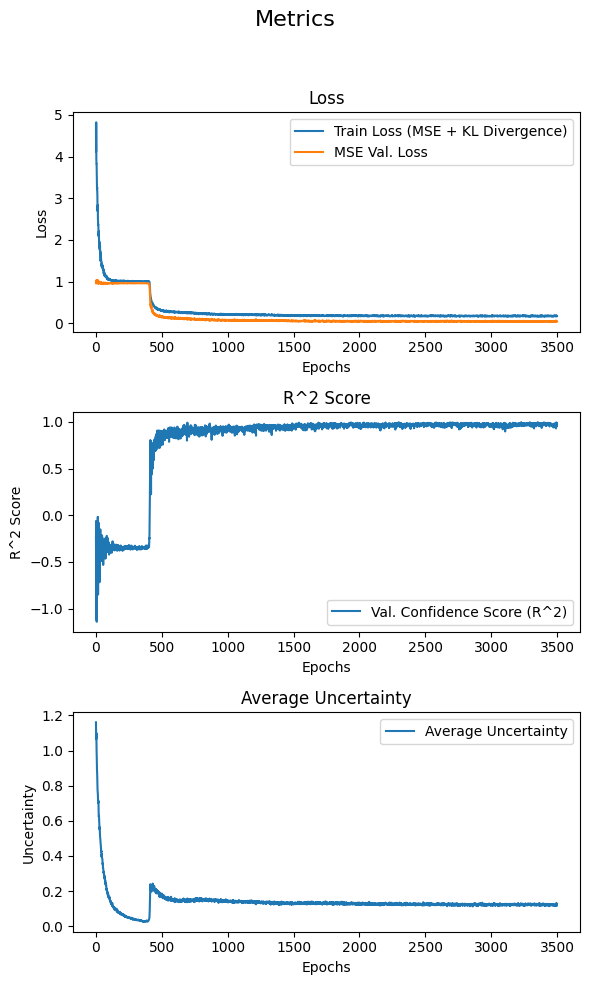

In [33]:
# Plot training history
fig, axes = plt.subplots(3, 1, figsize=(6, 10))
plt.suptitle('Metrics', fontsize=16)

# Losses
axes[0].plot(history['train_loss'], label='Train Loss (MSE + KL Divergence)')
axes[0].plot(history['val_loss'], label='MSE Val. Loss')
axes[0].set_title('Loss')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].legend()

# Confidence Score
axes[1].plot(history['r2'], label='Val. Confidence Score (R^2)')
axes[1].set_title('R^2 Score')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('R^2 Score')
axes[1].legend()

# Uncertainty
axes[2].plot(history['avg_uncertainty'], label='Average Uncertainty')
axes[2].set_title('Average Uncertainty')
axes[2].set_xlabel('Epochs')
axes[2].set_ylabel('Uncertainty')
axes[2].legend()


plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [34]:
# Get the metrics
model.eval()
y_true = y_test.numpy()
y_pred = []
uncertainties = []

with torch.no_grad():
    for X_batch, Y_batch in test_loader:
        outputs_list = [model(X_batch, mc_dropout=True) for _ in range(1000)] # Increase the number of MC samples for better uncertainty estimation
        outputs_stack = torch.stack(outputs_list)  # Shape: (mc_samples, batch_size, num_classes)
        outputs_mean = outputs_stack.mean(dim=0)  # Average prediction
        outputs_std = outputs_stack.std(dim=0)
        y_pred.extend(outputs_mean.cpu().numpy())
        uncertainties.extend(outputs_std.mean(dim=1).cpu().numpy())

y_pred = np.array(y_pred).reshape(-1, 1)

# Unscale the predictions and true values
y_pred = target_scaler.inverse_transform(y_pred)
y_true = target_scaler.inverse_transform(y_true)

In [35]:
# MAE
mae = mean_absolute_error(y_true, y_pred)
print(f"Mean Absolute Error (MAE): {mae:.4f}")

# RMSE
rmse = root_mean_squared_error(y_true, y_pred)
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

# R^2 Score
r2 = r2_score(y_true, y_pred)
print(f"R^2 Score: {r2:.4f}")

# Average Uncertainty
avg_uncertainty = np.mean(uncertainties)
print(f"Average Uncertainty: {avg_uncertainty:.4f}")

# Explained Variance Score
evs = explained_variance_score(y_true, y_pred)
print(f"Explained Variance Score: {evs:.4f}")

# this model doesn't work that well, but this dataset
# is very noise and similar results were achieved with Classic ML and ANN in previous courses

Mean Absolute Error (MAE): 0.5298
Root Mean Squared Error (RMSE): 0.6462
R^2 Score: 0.9522
Average Uncertainty: 0.1266
Explained Variance Score: 0.9537


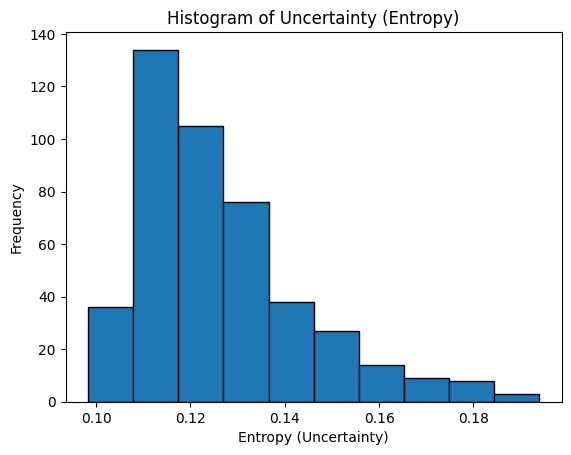

In [36]:
# plot uncertainty histogram
plt.hist(uncertainties, bins=10, edgecolor='k')
plt.xlabel('Entropy (Uncertainty)')
plt.ylabel('Frequency')
plt.title('Histogram of Uncertainty (Entropy)')
plt.show()

# in optimal case, entropy is stacked on the left side
# with only a small number of uncertainty on the high end

# this particular example is a very bad result, most uncertainty
# is in the high end

# the multi-category version is not usable by default in regression (because we don't have target categories)
# but it might be possible to use binning to inspect in which price ranges the uncertainties happen the most

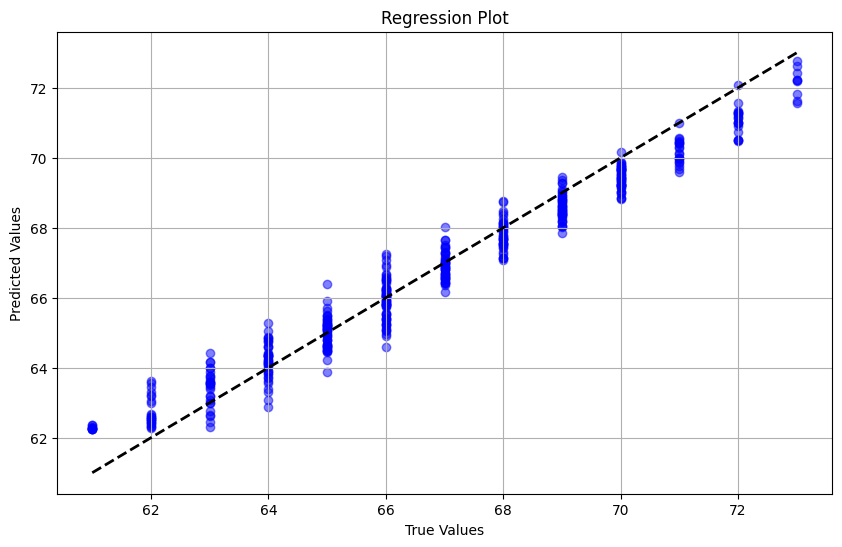

In [37]:
 # Regression plot
plt.figure(figsize=(10, 6))
plt.scatter(y_true, y_pred, alpha=0.5, color='blue')
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'k--', lw=2)
plt.title('Regression Plot')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.grid()
plt.show()

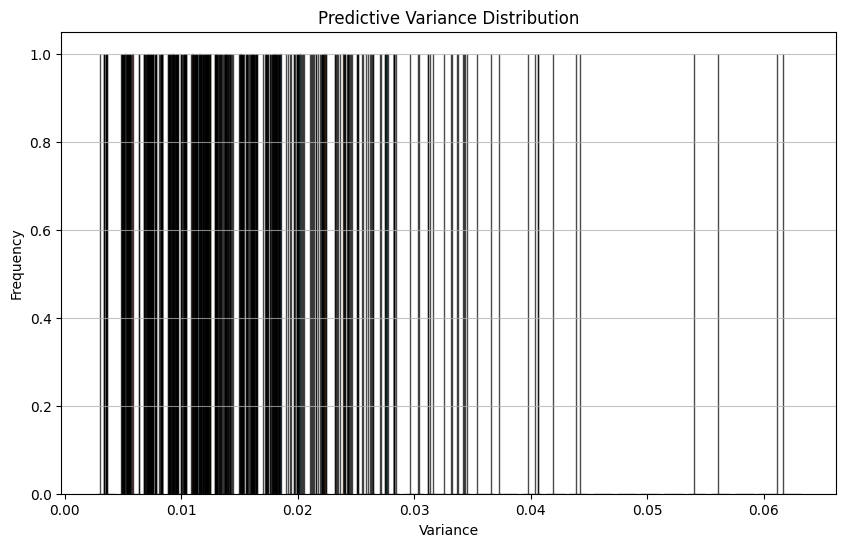

In [38]:
 # original code from ChatGPT and modified for this project (data and neural network structure)
# Assuming `model` performs MC Dropout and `test_loader` provides data
variances = []  # List to store predictive variance (or standard deviation)

model.eval()
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        # Perform multiple forward passes for MC Dropout
        outputs_list = [model(X_batch, mc_dropout=True) for _ in range(10)]
        outputs_stack = torch.stack(outputs_list)

        # Calculate variance across the predictions
        variance = outputs_stack.var(dim=0).cpu().numpy()  # Variance of each prediction
        variances.extend(variance)

# Plot predictive variance (uncertainty)
plt.figure(figsize=(10, 6))
plt.hist(variances, bins=30, alpha=0.7, edgecolor='black')
plt.title('Predictive Variance Distribution')
plt.xlabel('Variance')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

# most values should stack close to 0.0... otherwise it usually means noise in the dataset or underfitting
# or difficult data points / overlap

# so improve dataset or model structure / hyperparameters

In [39]:
# ORIGINAL CODE FROM CHATGPT AND MODIFIER FOR THE TESTER ROW STRUCTURE FROM EARLIER COURSES

# Define the function for prediction with uncertainty
def predict_with_uncertainty(model, data, feature_scaler, target_scaler, mc_samples=100):
    """
    Predict the price and uncertainty (using MC Dropout) for a new row of data.

    :param model: The trained Bayesian Neural Network model
    :param data: Processed input data for prediction
    :param feature_scaler: Scaler for the input features (used during training)
    :param target_scaler: Scaler for the target variable (price) used during training
    :param mc_samples: Number of Monte Carlo samples to estimate uncertainty
    :return: predicted_price, uncertainty (standard deviation)
    """
    model.eval()  # Set the model to evaluation mode
    predictions = []

    with torch.no_grad():
        for _ in range(mc_samples):
            # Apply MC dropout during inference
            prediction = model(data, mc_dropout=True)  # Get predictions using MC dropout
            predictions.append(prediction.cpu().numpy())

    predictions = np.array(predictions).flatten()  # Flatten predictions to 1D array

    # Compute the mean (predicted value) and the uncertainty (standard deviation)
    predicted_score = predictions.mean()
    uncertainty = predictions.std()

    # Inverse transform the predicted price and uncertainty to original scale
    predicted_score = target_scaler.inverse_transform([[predicted_score]])[0][0]  # Rescale predicted price

    # Uncertainty might need to be scaled back to original scale (if it was scaled during training)
    # uncertainty = uncertainty * target_scaler.scale_[0]  # Scale the uncertainty back to original price scale

    return predicted_score, uncertainty


# Example new row for prediction (using your dataset)
tester_row = {
    "Hours_Studied": 25,
    "Attendance": 69,
    "Parental_Involvement": 2,
    "Access_to_Resources": 0,
    "Extracurricular_Activities": 0,
    "Sleep_Hours": 7,
    "Previous_Scores": 76,
    "Motivation_Level": 0,
    "Internet_Access": 1,
    "Tutoring_Sessions": 1,
    "Family_Income": 2,
    "Teacher_Quality": 0,
    "School_Type": 1,
    "Peer_Influence": 0,
    "Physical_Activity": 2,
    "Learning_Disabilities": 0,
    "Parental_Education_Level": 0,
    "Distance_from_Home": 0,
    "Gender": 0
}



# Convert the new data to pandas DataFrame
tester_row = pd.DataFrame([tester_row])

# Normalize the input features using feature_scaler (if you scaled them during training)
processed_data = feature_scaler.transform(tester_row.values)

# Convert the scaled data into a tensor
processed_data_tensor = torch.tensor(processed_data, dtype=torch.float32)

# Call the prediction function to get the price and uncertainty
predicted_score, uncertainty = predict_with_uncertainty(model, processed_data_tensor, feature_scaler, target_scaler)

# Output the result
print("\nEstimated score for that student is:")
print(f"$ {round(predicted_score, 2)}")
print(f"Uncertainty (Standard Deviation): {round(uncertainty, 2)}")
print("----------------")


Estimated score for that student is:
$ 66.83
Uncertainty (Standard Deviation): 0.11999999731779099
----------------
